# How many Pro Players are out there ?

On [PlayGwent]() only data from the top 2860 pro players is shared. Though it is like there are (many) more. We'll try using some data science on the MMR scores from players from previous seasons to estmate how many players are actually out there. This can be done because the very first season in Masters 2 (Season of the Wolf) the total number of active players (MMR 2400 indicating at least 25 games were played) was about that threshold (the lowest MMR that season is 2407).

Assuming the distribution of MMR scores remains similar accross seasons, we can leverage that to estimate the total number of players for seasons where there were more players. The idea is to determine the percentage of players with an MMR higher than 9700, 9800, 9900, 10000 and 10100 from the first season and, using those percentages, extrapolate the number of players above those thresholds to the total number of players for other seasons.

In [1]:
%load_ext nb_black

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
df = pd.read_excel("./output/player_stats.xlsx").drop(columns=["Unnamed: 0"])
seasons_df = (
    df.groupby(["season"])
    .agg(
        min_mmr=pd.NamedAgg("mmr", "min"),
        max_mmr=pd.NamedAgg("mmr", "max"),
        num_matches=pd.NamedAgg("matches", "sum"),
    )
    .reset_index()
)

seasons_df

,season,min_mmr,max_mmr,num_matches
0,M2_01 Wolf 2020,2407,10484,699496
1,M2_02 Love 2020,7776,10537,769358
2,M2_03 Bear 2020,9427,10669,862678
3,M2_04 Elf 2020,9666,10751,1004830
4,M2_05 Viper 2020,9635,10622,859640
5,M2_06 Magic 2020,9624,10597,793401
6,M2_07 Griffin 2020,9698,10667,996742
7,M2_08 Draconid 2020,9666,10546,838212
8,M2_09 Dryad 2020,9678,10725,855528


<IPython.core.display.Javascript object>

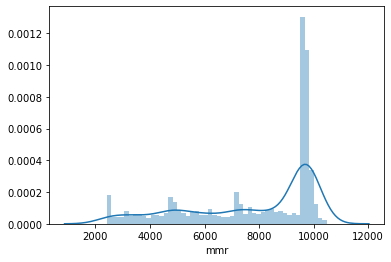

<IPython.core.display.Javascript object>

In [3]:
sns.distplot(df[df["season"] == "M2_01 Wolf 2020"]["mmr"], bins=50)
plt.show()

In [4]:
percentiles = np.percentile(
    df[df["season"] == "M2_01 Wolf 2020"]["mmr"], [x / 2 for x in range(0, 200, 1)]
)
percentiles_df = pd.DataFrame(
    {"percentile": [x / 2 for x in range(0, 200, 1)], "mmr": percentiles}
)
percentiles_df

,percentile,mmr
0,0.0,2407.000
1,0.5,2413.285
2,1.0,2426.000
3,1.5,2447.855
4,2.0,2477.420
...,...,...
195,97.5,10037.575
196,98.0,10064.000
197,98.5,10088.145
198,99.0,10135.170


<IPython.core.display.Javascript object>

## Test case

To test if the method actually worked, I got into Pro Rank during the Season of the Dryad and stopped playing ranked (actually stopped playing that season entirely as I didn't have time to climb). The result was that I had an unimpressive MMR of 3360, good for rank of 12816. If our estimates work we should get a number that is in that order of magnitude. 

We'll check the percentage of players who are at MMR 9678 during the first season (74 percent is at or below this threshold, so 26 is above. So if the total number of players listed, 2 860 corresponds with 26 % of the total Pro players, we can quickly figure out the total number of player should be around 11 000. Still some ways off the total number I know by getting into Pro Rank and staying there. Actually, using the same trick we can use the MMR I got and the position to get an approximation of 13782 Pro Players with MMR 2400 or above that season. However, for now this is close enough.

In [5]:
# MMR cutoff to appear on pro ladder during the Season of the Dryad = 9678
percentiles_df[percentiles_df.mmr >= 9678][:1]

,percentile,mmr
148,74.0,9678.0


<IPython.core.display.Javascript object>

In [6]:
(2860 / 26) * 100

11000.0

<IPython.core.display.Javascript object>

## Using multiple cutoffs

As small changes in the number of players can cause a big shift, here we'll use multiple MMR cutoffs to make the estimations and do some statistics on them to see if we can get close to the total number of players we are aware off.

In [7]:
seasons = list(set(df["season"]))

output = []

for i in [9700, 9800, 9900, 10000, 10100]:
    for season in seasons:
        players_above_threshold = (
            df[(df.season == season) & (df.mmr >= i)]
            .groupby(["season"])
            .agg(num_players=pd.NamedAgg("mmr", "count"))
            .reset_index()
        ).iloc[0]["num_players"]
        percentile = int(100 - percentiles_df[percentiles_df.mmr > i][:1]["percentile"])

        output.append(
            {
                "season": season,
                "mmr_cutoff": i,
                "num_players": players_above_threshold,
                "total_players_est": players_above_threshold * 100 / percentile,
            }
        )

estimates_df = pd.DataFrame(output).sort_values("season")

<IPython.core.display.Javascript object>

In [8]:
estimate_summary = (
    estimates_df.groupby(["season"])
    .agg(
        low_estimate=pd.NamedAgg("total_players_est", "min"),
        max_estimate=pd.NamedAgg("total_players_est", "max"),
        mean_estimate=pd.NamedAgg("total_players_est", "mean"),
        std_err=pd.NamedAgg("total_players_est", "sem"),
    )
    .reset_index()
)
estimate_summary

,season,low_estimate,max_estimate,mean_estimate,std_err
0,M2_01 Wolf 2020,2900.000000,3600.0,3117.636364,124.944153
1,M2_02 Love 2020,4566.666667,7100.0,5621.151515,440.999682
2,M2_03 Bear 2020,6040.909091,10300.0,7332.181818,759.622655
3,M2_04 Elf 2020,9931.818182,18000.0,12322.363636,1493.522421
4,M2_05 Viper 2020,7766.666667,11400.0,9372.060606,727.332197
5,M2_06 Magic 2020,6800.000000,9800.0,8320.181818,618.201230
6,M2_07 Griffin 2020,12840.909091,19900.0,14684.181818,1331.303270
7,M2_08 Draconid 2020,9566.666667,13300.0,11187.151515,696.451999
8,M2_09 Dryad 2020,9733.333333,12600.0,11231.393939,462.041718


<IPython.core.display.Javascript object>

## Results ... maybe ...

So here we can see the minimum and maximum estimated numbers of Pro Players can differ a lot, and for the season of the Dryad even the max estimate is still at least 1000 players shy of the ground truth. Though, given the scarcity of data to work with and some of the assumptions we need to make (it is unlikely that the discribution remains exactly the same as buffs/nerfs to cards and new cards could affect how easy it is to reach a certain fMMR with specific factions) it is the best that can be done with the data at hand and it is probably close enough.

One thing I wanted to check if if there is a correlation between the number of games played by the top 2860 players and the estimated total number of players. This can easily be done by mergin our estimations with the number of players in the season summaries and plotting them using a scatter plot (or regplot to have a regression line in the plot). We'll do this for the top 500 players seperately as well to see if the trend holds for that section of the players.

In [12]:
# same thing but only considering the top 500 players
seasons_top500only_df = (
    df[pd.to_numeric(df["rank"]) <= 500]
    .groupby(["season"])
    .agg(
        min_mmr=pd.NamedAgg("mmr", "min"),
        max_mmr=pd.NamedAgg("mmr", "max"),
        num_matches=pd.NamedAgg("matches", "sum"),
    )
    .reset_index()
)

merged_df = pd.merge(
    seasons_df,
    seasons_top500only_df,
    how="inner",
    on="season",
    suffixes=("", "_top500"),
)
merged_df = pd.merge(merged_df, estimate_summary, how="inner", on="season").drop(
    columns=["min_mmr_top500", "max_mmr_top500"]
)

merged_df

,season,min_mmr,max_mmr,num_matches,num_matches_top500,low_estimate,max_estimate,mean_estimate,std_err
0,M2_01 Wolf 2020,2407,10484,699496,178323,2900.000000,3600.0,3117.636364,124.944153
1,M2_02 Love 2020,7776,10537,769358,183972,4566.666667,7100.0,5621.151515,440.999682
2,M2_03 Bear 2020,9427,10669,862678,205834,6040.909091,10300.0,7332.181818,759.622655
3,M2_04 Elf 2020,9666,10751,1004830,251712,9931.818182,18000.0,12322.363636,1493.522421
4,M2_05 Viper 2020,9635,10622,859640,207622,7766.666667,11400.0,9372.060606,727.332197
5,M2_06 Magic 2020,9624,10597,793401,188536,6800.000000,9800.0,8320.181818,618.201230
6,M2_07 Griffin 2020,9698,10667,996742,259713,12840.909091,19900.0,14684.181818,1331.303270
7,M2_08 Draconid 2020,9666,10546,838212,210198,9566.666667,13300.0,11187.151515,696.451999
8,M2_09 Dryad 2020,9678,10725,855528,202433,9733.333333,12600.0,11231.393939,462.041718


<IPython.core.display.Javascript object>

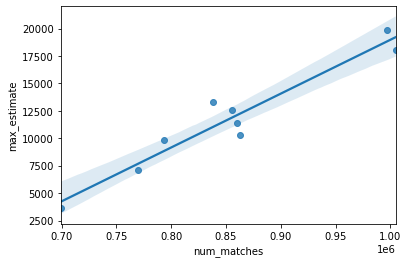

<IPython.core.display.Javascript object>

In [10]:
sns.regplot(data=merged_df, x="num_matches", y="max_estimate")
plt.show()

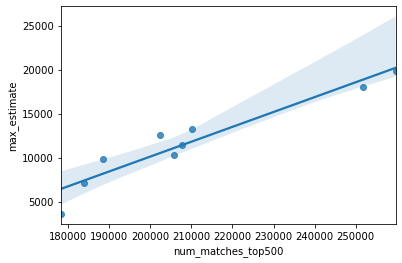

<IPython.core.display.Javascript object>

In [11]:
sns.regplot(data=merged_df, x="num_matches_top500", y="max_estimate")
plt.show()

There is a clear and mostly linear correlation between the number of Pro Ranked players and the number of games played by both the top 2860 and top 500 players.